# Variational Quantum Eigen Solver on 3 Qubit Circuit
Find the ground state energy eigen value of the given hamiltonian 
$$ Hamiltonian = \begin{bmatrix} 0.3 & 0 & 0 & 0 & 0 & 1.1 & 0 & 0 \\ 0 & -0.3 & 0 & 0 & 1.1 & 0 & 0 & 0\\ 0 & 0 & -0.3 & 0 & 0 & 0 & 0 & 0.7 \\ 0 & 0 & 0 & 0.3 & 0 & 0 & 0.7 & 0 \\ 0 & 1.1 & 0 & 0 & -0.3 & 0 & 0 & 0 \\ 1.1 & 0 & 0 & 0 & 0 & 0.3 & 0 & 0 \\ 0 & 0 & 0 & 0.7 & 0 & 0 & 0.3 & 0 \\ 0 & 0 & 0.7 & 0 & 0 & 0 & 0 & -0.3 \end{bmatrix}$$

Above Hamiltonian can be decomposed to fermionic basis
 $$Hamiltonian =  0.2(X \otimes Z \otimes X) + 0.9(X \otimes I \otimes X) + 0.3(Z \otimes Z \otimes Z) $$

Where $X,Z$ are pauli's spin matrices and $I$ is the Identity matrix


### Solution with Numpy Linalg

In [1]:
import numpy as np


X = np.array([[0,1],[1,0]])       # pauli's sigma-x matrix
Z = np.array([[1,0],[0,-1]])      # pauli's sigma-z matrix
I = np.array([[1,0],[0,1]])       # 2X2 Identity matrix



A = np.kron(X,np.kron(Z,X))       # XZX
B = np.kron(X,np.kron(I,X))       # XIX
C = np.kron(Z,np.kron(Z,Z))       # ZZZ
H = (0.2*A) + (0.9*B) + (0.3*C)   # "H = 0.2*XZX + 0.9*XIX + 0.3*ZZZ" is the hamiltonian

#print(H)
eig_vals,eig_vecs = np.linalg.eig(H)
print('Lowest eigen value is:',round(eig_vals.min(),3))

Lowest eigen value is: -1.4


## VQE on IBM QASM simulator
Nesessary imports are performed like Numpy, qiskit, Scipy etc.

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer as Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.visualization import *
from scipy.optimize import minimize
from scipy import array
from random import random
#%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from qiskit import *
#plt.style.use('dark_background')
#style = {'backgroundcolor': '#282c34'}

## Ansatz: Trial solution
A choice of ANSATZ of specific choice with 3 variational parameters is given here with depth of 3

In [3]:
def parametric_state(theta): #------------- Creates ANSATZ
    """
    Creates ANSATZ with an 
    angle taking as parameter &
    returns a quantum circuit.
    :param theta: angle in radian
    :return: quantum circuit
    """
    q = QuantumRegister(3)
    c = ClassicalRegister(3)
    circuit = QuantumCircuit(q,c)
    for i in range(3):  #----------------circuit depth
        circuit.ccx(q[0],q[1],q[2] )
        circuit.ry(theta[0],q[0])
        circuit.ry(theta[1],q[1])
        circuit.ry(theta[2],q[2])
    return circuit

### Sample Ansatz with 3 arbitrary angles

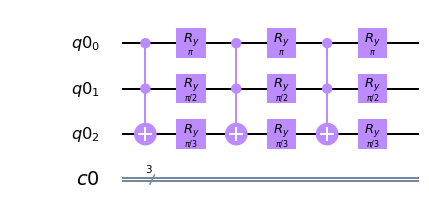

In [4]:
theta = [np.pi,np.pi/2,np.pi/3]
parametric_state(theta).draw(output='mpl')

Above Hamiltonian can be decomposed to fermionic basis
 $$Hamiltonian =  0.2XZX + 0.9XIX + 0.3ZZZ $$

Where $X,Z$ are pauli's spin matrices and $I$ is the Identity matrix. In this section we developed 3 functions for these 3 sub-hamiltonians, which gives expectation value of each sub-hamiltonian.
  $$Hamiltonian =  H_{1} + H_{2} + H_{3} $$
Where $ H_{1} = 0.2XZX $   ,       $  H_{2} = 0.9XIX $    ,     $ H_{3} = 0.3ZZZ $ are the sub-hamiltonians


Since the Pauli $X$ has +1, -1 eigenvalues for its respective basis, we know we'll get the same outcome for expectation. This means our above equation for calculating expectation from probabilities works for them too. 

** Changing basis **

Finally we have to measure the Pauli observables in their respective eigenbases. 


$Z \otimes Z\otimes Z$ has the computational basis as its eigenbasis, so we don't need to do anything. 

$X \otimes Z\otimes X$ and $X \otimes I\otimes X$  has the Hadamard basis as its eigenbasis, since $X \ket{+} = \ket{+}$ and $X \ket{-} = - \ket{-}$. So we need to apply a basis transformation that maps $\ket{+}, \ket{-} \rightarrow \ket{0}, \ket{1}$. Of course, the Hadamard gate does this, so we need to just apply it to both qubits in the ansatz. 

In [5]:
## All the necessary functions for the algorithm is written here ##

def XZX(theta): #--------------------------------------------H1
    """
    Gives expectation value of XZX
    sub-hamiltonian from measurement
    on parametric state.
    :param theta: angle in radian
    :return: expectation value of XZX
    """
    circuit = parametric_state(theta)
    ###########  Basis Transformation on XZX ###########
    q = circuit.qregs[0]
    c = circuit.cregs[0]
    circuit.ry(-np.pi/2, q[0])
    circuit.ry(-np.pi/2, q[2])
    circuit.measure(q,c)
    ############  XZX measurement  ##############
    exp_XZX = measurement(circuit)
    return exp_XZX
    
def XIX(theta): #-------------------------------------------H2
    """
    Gives expectation value of XIX
    sub-hamiltonian from measurement
    on parametric state.
    :param theta: angle in radian
    :return: expectation value of XIX
    """
    circuit = parametric_state(theta)
    ########### Basis Transformation on XIX #########
    q = circuit.qregs[0]
    c = circuit.cregs[0]
    circuit.ry(-np.pi/2, q[0])
    circuit.ry(-np.pi/2, q[2])
    circuit.measure(q,c)
    ############ XIX Measurement ###########  
    exp_XIX = measurement(circuit)
    return exp_XIX

def ZZZ(theta): #-------------------------------------------H3
    """
    Gives expectation value of ZZZ
    sub-hamiltonian from measurement
    on parametric state.
    :param theta: angle in radian
    :return: expectation value of ZZZ
    """
    circuit = parametric_state(theta)
    ##########################################
    q = circuit.qregs[0]
    c = circuit.cregs[0]
    circuit.measure(q,c)
    ###########  ZZ measurement ###############  
    exp_ZZZ = measurement(circuit)
    return exp_ZZZ


This $vqe$ function adds up the expectation value of all the sub hamiltonians for all parametric(angles) states and return total expectation value of the complete hamiltonian. 

In [6]:
def vqe(theta):    #------------------- creates ansatz measures and performs addition to get the eigen value
    """
    Contain the complete Hamiltonian
    :param theta: angle is radian
    :return: expectation value of whole hamiltonian
    """                                                           
    E = (0.2*XZX(theta)) + (0.9*XIX(theta)) + (0.3*ZZZ(theta))    ## H = 0.2XZX + 0.9XIX + 0.3ZZZ
    return E

"key_check" will be used to extract number of counts of each basis state of this 3 qubit system

In [7]:
def key_check(my_dict: dict, my_key: str):
    """
    If key is missing returns 0
    otherwise the corresponding value.
    :param my_dict: the dictionary
    :param my_key: key (string)
    :return: 0 or value corresponding to key
    """
    response = 0
    if my_key in my_dict:
        response = my_dict[my_key]
    return response

$measurement$ is used to perform measurement of every qubits in |0> , |1> basis gives the total expectation value
This is our main quantum modeule

In [8]:
def measurement(circuit):  # ------------------ Takes a quantum circuit and perform measurement
    """
    Takes the quantum circuit as
    input to perform measurement
    :param circuit: quantumm circuit
    :return: expectation value
    """
    shots =1024
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    n100 = key_check(counts,'100')
    n111 = key_check(counts,'111')
    n001 = key_check(counts,'001')
    n010 = key_check(counts,'010')
    n000 = key_check(counts,'000')
    n101 = key_check(counts,'101')
    n110 = key_check(counts,'110')
    n011 = key_check(counts,'011')
    expectation_value = ((n000+n111)-(n100+n001+n010+n101+n110+n011))/shots 
    return expectation_value

As per the idea of VQE for optimization of Ansatz parameters we need to use some classical algorithm. Here we are using  Scipy "Powell" optimizer. We could have used other classical optimizers like COBYLA, Nelder-Mead etc

In [9]:
###########  VQE by Scipy Optimizers  ##############
theta = [2*np.pi,2*np.pi,2*np.pi]
result = minimize(vqe, theta, method="Powell")
print('Ground state energy from VQE is {}'.format(result.fun))
print('Success Status:',result.success,',',result.message)

Ground state energy from VQE is -1.4000000000000001
Success Status: True , Optimization terminated successfully.


### References
1. "Quantum Algorithms: Variational-Quantum-Eigensolver" by 
Dawid Kopczyk  http://dkopczyk.quantee.co.uk/vqe/#easy-footnote-2
2. Implementation of 2 qubit VQE https://github.com/speQtrum/qreepy/blob/master/2_qubit_VQE.ipynb
3. "Variational Quantum Eigensolver explained" by Michał Stęchły  https://www.mustythoughts.com/post/variational-quantum-eigensolver-explained
4. "Variational quantum eigensolver" by Davit Khachatryan https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb